<a href="https://colab.research.google.com/github/lucasmoratof/customers_review_project/blob/master/ML_for_Prediction_of_Review_Quality.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Creating a ML model to predict review quality at OLIST

On this notebook we are going to have fun together doing the following steps:

- **Merging** the datasets;
- Creating the **target feature** and an aditional feature;
- Performing **data cleaning**: feature selection and removing null values and outliers;
- Pre-processing: feature selection, One Hot Encode for multicategorical features and dealing with unbalanced target data;
- Select the best among 3 classifiers: **KNN, Random Forest and SVM**;
- Performing **Hyperparameter tunning**;
- Using **k-fold** for model validation;
- Checking the good stuff that we got.

First, let's start the python party with our best libraries friends:

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import pyplot as plt
from functools import reduce
from scipy import stats

# SKlearn wants to bring almost the whole family:
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.utils import resample
from sklearn.model_selection import RandomizedSearchCV

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
import warnings; warnings.simplefilter('ignore')

Now, let's understand how data is organized, and load the datasets:

![](https://github.com/olist/work-at-olist-data/raw/master/images/schema.png)
*source: [github](https://github.com/olist/work-at-olist-data)* 

In [0]:
# Here we use the link to the raw data hosted at GitHub

customers = pd.read_csv('https://raw.githubusercontent.com/olist/work-at-olist-data/master/datasets/olist_customers_dataset.csv')
order_items = pd.read_csv('https://raw.githubusercontent.com/olist/work-at-olist-data/master/datasets/olist_order_items_dataset.csv')
order_payments = pd.read_csv('https://raw.githubusercontent.com/olist/work-at-olist-data/master/datasets/olist_order_payments_dataset.csv')
order_reviews = pd.read_csv('https://raw.githubusercontent.com/olist/work-at-olist-data/master/datasets/olist_order_reviews_dataset.csv')
orders= pd.read_csv('https://raw.githubusercontent.com/olist/work-at-olist-data/master/datasets/olist_orders_dataset.csv')
products = pd.read_csv('https://raw.githubusercontent.com/olist/work-at-olist-data/master/datasets/olist_products_dataset.csv')
sellers = pd.read_csv('https://raw.githubusercontent.com/olist/work-at-olist-data/master/datasets/olist_sellers_dataset.csv')
prod_cat_trans = pd.read_csv('https://raw.githubusercontent.com/olist/work-at-olist-data/master/datasets/product_category_name_translation.csv')

## **Merging** the datasets

Hummm, lot's of good stuff here. We are using all tables except geolocation as it isn't particullary relevant for review analysis. 

Now, Using the orders table as the core of the process, we will merge everything together, and after we will filter the rows to keep just the **orders which have one product only**.

In [0]:
# First, we will merge the three datasets that share the same key "order_id":

dfs = [orders, order_payments, order_reviews, order_items]
orders_full = reduce(lambda left, right: pd.merge(left,right, how= 'left', on= 'order_id'), dfs)

# Now, adding the remaing dataframes using the usual syntax:
orders_cust = orders_full.merge(customers, how= 'left', on= 'customer_id')

orders_cust_prod = orders_cust.merge(products, how= 'left', on= 'product_id')

final_df = orders_cust_prod.merge(sellers, how= 'left', on='seller_id')

In [4]:
# Now, we need to translate product_category from Portuguse to English:

# first, transform the dataframe into a dictionary:
cat_dic = dict(zip(prod_cat_trans['product_category_name'], prod_cat_trans['product_category_name_english']))

# then, apply the dictionary into the column:
final_df["product_category_name"].replace(cat_dic, inplace=True)

# now, display the first rows to check if it worked:
final_df['product_category_name'].head(3)

0    housewares
1    housewares
2    housewares
Name: product_category_name, dtype: object

In [5]:
# And finally, removing orders with more than one product

final_df.drop_duplicates('order_id', keep=False, inplace=True)

# check if it worked (there should be 0 duplicated rows on the column now):
final_df['order_id'].duplicated().sum()

0

In [6]:
# Now, let's have a look on the first rows:
print(final_df.shape)

final_df.head(3)

(86486, 45)


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,payment_sequential,payment_type,payment_installments,payment_value,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,seller_zip_code_prefix,seller_city,seller_state
3,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,1.0,boleto,1.0,141.46,8d5266042046a06655c8db133d120ba5,4,Muito boa a loja,Muito bom o produto.,2018-08-08 00:00:00,2018-08-08 18:37:50,NaN,NaN,NaN,NaN,NaN,NaN,1.0,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.7,22.76,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,perfumery,29.0,178.0,1.0,400.0,19.0,13.0,19.0,31570.0,belo horizonte,SP
4,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,1.0,credit_card,3.0,179.12,e73b67b67587f7644d5bd1a52deb1b01,5,NaN,NaN,2018-08-18 00:00:00,2018-08-22 19:07:58,NaN,NaN,NaN,NaN,NaN,NaN,1.0,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,2018-08-13 08:55:23,159.9,19.22,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO,auto,46.0,232.0,1.0,420.0,24.0,19.0,21.0,14840.0,guariba,SP
5,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00,1.0,credit_card,1.0,72.20,359d03e676b3c069f62cadba8dd3f6e8,5,NaN,O produto foi exatamente o que eu esperava e e...,2017-12-03 00:00:00,2017-12-05 19:21:58,NaN,NaN,NaN,NaN,NaN,NaN,1.0,d0b61bfb1de832b15ba9d266ca96e5b0,66922902710d126a0e7d26b0e3805106,2017-11-23 19:45:59,45.0,27.20,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN,pet_shop,59.0,468.0,3.0,450.0,30.0,10.0,20.0,31842.0,belo horizonte,MG


## Creating the target feature and an aditional feature

Our focus here is to discover if a review will be good or not, which is a yes or no question. In our dataset we have the column *reviews_scores*, which has values from 1 to 5, where 1 is bad and 5 is excellent. 

To transforme this into a binary value, we will do the following:

- Transform values 1, 2 and 3 into 0, meaning it is not a good review;
- Values 4 and 5 will be cosidered a good review, with value 1.

In [0]:
# The following code will create a new column 'is_good_review', which will evaluate the 'review_score'. If the value is equal or less than 3,
# it returns 1 if review is higher than 3, otherwise it returns 0.

final_df['is_good_review'] = final_df['review_score'].apply(lambda x: 1 if x > 3 else 0)

Now, we are going to create a new feature with the difference in days between an order and the delivery. To accomplish this, we need first to convert the columns into date format and then perform the aritimetical operation, keeping just the number of days:

In [8]:
# converting dates for datetime format
final_df[['order_purchase_timestamp','order_delivered_customer_date']] =\
final_df[['order_purchase_timestamp','order_delivered_customer_date']].apply(pd.to_datetime, format='%Y-%m-%d')

# Check data type
final_df['order_purchase_timestamp'].dtype # the result could be also <M8[ns], which means a datatime64

dtype('<M8[ns]')

In [9]:
final_df['delivery_in_days'] = (final_df['order_delivered_customer_date'] - final_df['order_purchase_timestamp']).dt.days

final_df['delivery_in_days'].head()

3    13.0
4     9.0
5    13.0
6     2.0
7    16.0
Name: delivery_in_days, dtype: float64

## Data cleaning: feature selection and removing null values and outliers

Feature Selection

From the available features, I've decided to keep 12, including the target feature:

In [10]:
columns = ['order_status','delivery_in_days', 'product_id','product_category_name','product_photos_qty','price',
           'freight_value','payment_type','payment_installments','customer_city','seller_id','is_good_review']

final_df = final_df[columns]

print(final_df.shape)

(86486, 12)


[](http://)**Null Values**

In [11]:
# Checking the null values:

print('Percentage of missing values by feature')
final_df.isnull().sum() *100 / len(final_df)

Percentage of missing values by feature


order_status             0.000000
delivery_in_days         3.113799
product_id               0.863724
product_category_name    2.294013
product_photos_qty       2.294013
price                    0.863724
freight_value            0.863724
payment_type             0.000000
payment_installments     0.000000
customer_city            0.000000
seller_id                0.863724
is_good_review           0.000000
dtype: float64

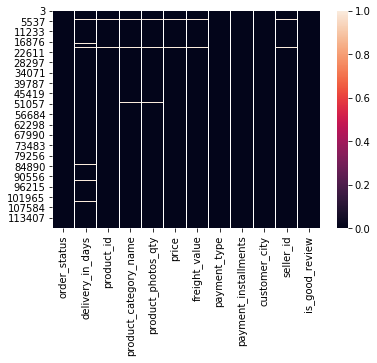

In [12]:
# Ploting the distribution of null values
sns.heatmap(final_df.isnull())

We have 3 columns with more than 1% of missing values. My approach will be:

- Fill the delivery in days with the mean value;
- As the amount of pictures can have impact on the review, I will replace the null values for 0;
- Product_id cannot be replaced, as it represents a category, so I'll drop the missing rows for it and all the other one with less than 1% of null values.

In [13]:
# filling the delivery days with the mean value:
final_df['delivery_in_days'].fillna(final_df['delivery_in_days'].mean(), inplace= True)

# fill product photos with 0
final_df['product_photos_qty'].fillna(value= 0, inplace=True)

# Dropping all other rows with null values:
final_df.dropna(how='any', axis=0, inplace=True)

# checking the shape and the number of null rows:
print(final_df.shape)
final_df.isnull().sum()

(84502, 12)


order_status             0
delivery_in_days         0
product_id               0
product_category_name    0
product_photos_qty       0
price                    0
freight_value            0
payment_type             0
payment_installments     0
customer_city            0
seller_id                0
is_good_review           0
dtype: int64

**Outliers**

To try to identify if we have outliers, we will check the stats for the numerical columns and plot a boxplot of one of the features:

In [14]:
# Checking the stats
num_cols_names = final_df.select_dtypes(exclude=['object']).columns
num_df = final_df[num_cols_names]

num_df.describe()

,delivery_in_days,product_photos_qty,price,freight_value,payment_installments,is_good_review
count,84502.000000,84502.000000,84502.000000,84502.000000,84502.000000,84502.000000
mean,12.155481,2.283331,130.471586,20.442660,2.891932,0.788798
std,9.515094,1.764627,196.431864,16.308875,2.662628,0.408164
min,0.000000,1.000000,0.850000,0.000000,0.000000,0.000000
25%,6.000000,1.000000,44.900000,13.430000,1.000000,1.000000
50%,10.000000,2.000000,79.990000,16.490000,2.000000,1.000000
75%,15.000000,3.000000,144.990000,21.420000,4.000000,1.000000
max,209.000000,20.000000,6735.000000,409.680000,24.000000,1.000000


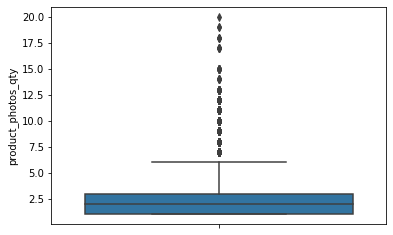

In [15]:
# Showing the presence of outliers in a feature
sns.boxplot(y=num_df['product_photos_qty'])

Both approaches showed that we have indeed outliers in our data, that we need to remove before going to modeling it.

As a solution to deal with outliers on the dataset, I will use the z-score in all numerical features, dropping the values with values higher them the threshold of 3. 

If you want to understand more about why I'm using this approach, you can check the explantion **[here](https://medium.com/datadriveninvestor/outliers-no-more-using-the-power-of-z-score-against-the-evil-eb50fd914b29?)**.

In [16]:
# Calculate the zscore for each feature
z_numbers= np.abs(stats.zscore(num_df)) 

# drop the rows with z-scores higher than the threshold 3
num_df = final_df[(z_numbers < 3).all(axis=1)]

# leave just the numerical columns, we will concatenate it later
num_df = num_df[num_cols_names]

#checking the size of the dataset after the change
print(num_df.shape)
num_df.head()

(79070, 6)


,delivery_in_days,product_photos_qty,price,freight_value,payment_installments,is_good_review
3,13.0,1.0,118.7,22.76,1.0,1
4,9.0,1.0,159.9,19.22,3.0,1
5,13.0,3.0,45.0,27.20,1.0,1
6,2.0,4.0,19.9,8.72,1.0,1
7,16.0,1.0,147.9,27.36,6.0,1


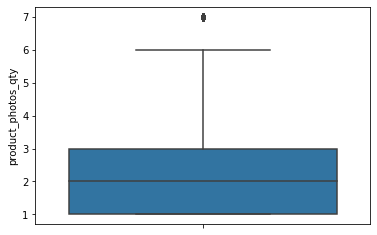

In [17]:
# Checking the same column we did the boxplot previously to check if it worked. 
sns.boxplot(y=num_df['product_photos_qty'])

## Pre-processing: feature selection, One Hot Encode for multicategorical features and dealing with unbalanced target data.

Now, we need to transform the categorical features into numerical. Let's check how many factors each one has:

In [18]:
# Separate the categorical data, later we will combine with the numerical data again:

cat_df = final_df.select_dtypes(include=['object']).copy()

for col in cat_df:
    print(col, 'has:', cat_df[col].value_counts().count(), 'categories')

order_status has: 7 categories
product_id has: 28189 categories
product_category_name has: 73 categories
payment_type has: 4 categories
customer_city has: 3975 categories
seller_id has: 2912 categories


We have features with 4 categories until almost 4 thousand categories, so the approach will be different for each one.

- For payment_type and order_status, as they have less than 10 categories each, I will just replace the values for numbers using a dictionary and the replace function;

- For the remaining features, one solution could be replacing each category to a number, but this would affect my model, as it can understand that city '1' has somehow more value than city '3345'. The approach I've chosen is to perform one hot encode, which creates one feature for each category, with the binary attribute 0 or 1. However, as I have thousands of different cities and products, I will follow what was suggested [here](http://proceedings.mlr.press/v7/niculescu09/niculescu09.pdf), where they used the top 10 of each of the categories, so, if the row contains a category not present on the top 10, the value will be zero, otherwise, it will be one. This way I will prevent to create too many new features.

**Applying replace within a dictionary of values**

In [0]:
# Applying replace() over payment_type and order_status

replace_map = {'order_status': {'delivered':1, 'shipped':2, 'canceled':3, 'invoiced':4,
                               'processing':5, 'unavailable':6, 'approved':7},
              'payment_type': {'credit_card':1, 'boleto':2, 'debit_card':3, 'voucher':4}}

cat_df.replace(replace_map, inplace=True)

**Handlng Multi Categorical Data: One Hot Encode** 

I've created the following function, that will do:

- 1: Create a top_x rank with the category names (the value of 'x' is one of the arguments, so the rank is customizable)
- 2: Use the values of the top_x categories to create the new columns, with value 1 when the row is from that category, and 0 when it's not.

I've decided to use just the top ten values to avoid the creation of hundreds of new features, that would make the job of the algorithms almost impossible.

In [0]:
def one_hot_top(df, variable, top_x):
    
    # making the rank for the variable:
    top_labels = [x for x in df[variable].value_counts().sort_values(ascending=False).head(top_x).index]
    
    # using the top list to create the new features:
    for label in top_labels:
        df[label] = np.where(df[variable]== label, 1, 0)
    
    # droping the original column as it wouldn't be used on the model
    df.drop(variable, axis=1, inplace=True)

Applying the function into the data frame:

In [0]:
cols = ['product_id','product_category_name', 'customer_city','seller_id']

for col in cols:
    one_hot_top(cat_df, col, 10)

**Concatenating the categorical and numerical variables**

In [22]:
print(num_df.shape, cat_df.shape)

(79070, 6) (84502, 42)


We can see that *cat_df* has more rows, this is due the fact that we didn't pass it through the z-score filter, so we need to specify in the concat to do *join='inner'*, and pass *num_df* first, so it will join by the index just the rows from *cat_df* that are in *num_df*.

In [0]:
# Doing the concatanation
model_df = pd.concat((num_df, cat_df), axis=1, join='inner')

In [24]:
# check the shape again
model_df.shape

(79070, 48)

**Dealing with unbalanced target data**

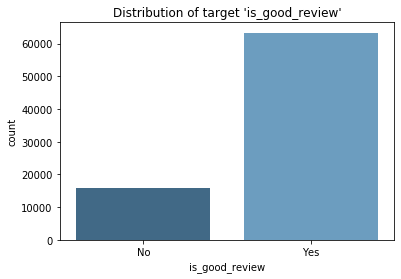

In [25]:
# Ploting the target distribution
sns.countplot(x='is_good_review', data=model_df, palette=("Blues_d"))
plt.xticks([0,1],['No','Yes'])
plt.title("Distribution of target 'is_good_review'")
plt.show()

We can see that there's way around 25% of bad reviews and 75% of good ones. This unbalanced data would negatively affect our models, so we need to deal with that. There is some possibilities, like:

- Upsample minority class;
- Undersample majority class;
- Generate synthetic samples;

To guarantee we will have enough data to run reliable models, the approach we are going to use is to upsample the less represented class.

In [26]:
# separate features and target
y= model_df['is_good_review']
X= model_df.drop('is_good_review', axis=1)

# Setting up train and test again
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=24)

# concatanate the training data back together
X= pd.concat([X_train, y_train], axis=1)

# separate minority and majority classes
good_r = model_df[model_df['is_good_review']== 1]
bad_r = model_df[model_df['is_good_review']== 0]

# upsample minority class
bad_r_upsampled = resample(bad_r,
                          replace=True,
                          n_samples= len(good_r),
                          random_state= 24)

# combine good and bad revies samples
model_df= pd.concat([good_r, bad_r_upsampled])

# check new class counts
model_df['is_good_review'].value_counts()

1    63322
0    63322
Name: is_good_review, dtype: int64

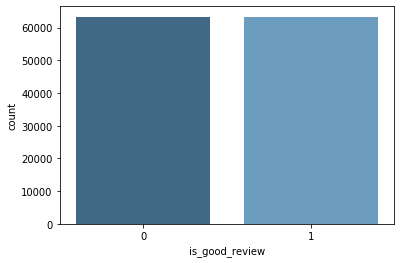

In [27]:
# Let's check the barchart to see if it worked.
sns.countplot(x='is_good_review', data=model_df, palette=("Blues_d"))

In [28]:
model_df.shape

(126644, 48)

## Select the best among 3 classifiers: KNN, Random Forest and SVM

To choose which algortihm to use, we need first to clearly state our question:

**"We want to predict if an order review will be positive or not"**

It's a binary classification problem, so my first approach will be to try 3 different classification methods:

- K-nearest neighbors (KNN);
- Random Forest;
- Support Vector Machine;

After analyzing the accuracy and recall of each one, select the algorithm which offers the most promising result.

** How could we test the three algorithms?**

Our approach is to follow the steps below:

- Try the algorithm using the default parameters;
- Run a loop with different values for one of the parameters of each algorithm;
- Plot the accuracy results;
- Print the confusion matrix for the best result.

**Setting the basics: splitting the data into training and testing sets:**

In [29]:
# Checking the size of train and test objects
print('y_train and y_test shapes:', y_train.shape, 'and', y_test.shape)
print('X_train and X_test shapes:', X_train.shape, 'and', X_test.shape)

y_train and y_test shapes: (55349,) and (23721,)
X_train and X_test shapes: (55349, 47) and (23721, 47)


### KNN 

In the first KNN interaction, I will use 7 neighbors.

In [30]:
# start the model
knn_model = KNeighborsClassifier() # using the default n_neighbors=5

# Fit the model into the train data
knn_model.fit(X_train, y_train)

# Predict on the test data
knn_y_pred = knn_model.predict(X_test)

# Check accuracy 
print(classification_report(y_test, knn_y_pred))

              precision    recall  f1-score   support

           0       0.49      0.18      0.26      4784
           1       0.82      0.95      0.88     18937

    accuracy                           0.80     23721
   macro avg       0.65      0.57      0.57     23721
weighted avg       0.75      0.80      0.76     23721



Text(0, 0.5, 'Testing Accuracy')

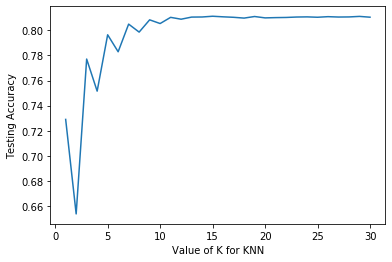

In [31]:
# now we will change the number of neighboors. The function below will retrieve accuracy for the range from 1 to 30
knn_range = range(1, 31)
knn_scores = {}
knn_scores_list = []

for k in knn_range:
    knn = KNeighborsClassifier(n_neighbors= k)
    knn.fit(X_train, y_train)
    knn_y_pred = knn.predict(X_test)
    knn_scores[k] = metrics.accuracy_score(y_test, knn_y_pred)
    knn_scores_list.append(metrics.accuracy_score(y_test, knn_y_pred))
    
# Now using the values of the loop to plot a graph with the performance
# ploting the relationship between K and the testing accuracy:
%matplotlib inline
plt.plot(knn_range, knn_scores_list)
plt.xlabel('Value of K for KNN')
plt.ylabel('Testing Accuracy')

The plot shows that the optimal value is k=15. Let's check it's performance and see the confusion matrix:

### Random Forest

As before, I will start with a random number of estimator, or tress. 100 is actually the default parameter of this classifier. 

In [32]:
# starting the model
rf_model = RandomForestClassifier(random_state=24) # n_estimators=10

# Fit
rf_model.fit(X_train, y_train)

# And predict
rf_y_pred = rf_model.predict(X_test)

# And finally, check the accuracy of our result
print(metrics.classification_report(y_test, rf_y_pred))

              precision    recall  f1-score   support

           0       0.64      0.24      0.35      4784
           1       0.83      0.97      0.90     18937

    accuracy                           0.82     23721
   macro avg       0.74      0.60      0.62     23721
weighted avg       0.80      0.82      0.79     23721



Text(0, 0.5, 'Testing Accuracy')

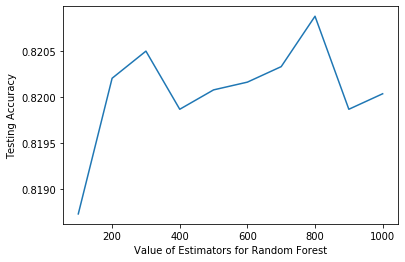

In [33]:
# on this model, we will try different values for the n_estimator parameter
rf_range = range(100, 1100, 100)
scores = {}
scores_list = []

for k in rf_range:
    rf_model = RandomForestClassifier(n_estimators=k)
    rf_model.fit(X_train, y_train)
    rf_y_pred = rf_model.predict(X_test)
    scores[k] = metrics.accuracy_score(y_test, rf_y_pred)
    scores_list.append(metrics.accuracy_score(y_test, rf_y_pred))
    
# ploting the relationship between K and the testing accuracy:
%matplotlib inline
plt.plot(rf_range, scores_list)
plt.xlabel('Value of Estimators for Random Forest')
plt.ylabel('Testing Accuracy')

Best performance was achieved with 1000 trees. Let's check the results:

In [34]:
# checking performance with 1000 trees
rf_model = RandomForestClassifier(n_estimators=1000, random_state=24)
rf_model.fit(X_train, y_train)
rf_y_pred = rf_model.predict(X_test)
print(metrics.classification_report(y_test, rf_y_pred))

              precision    recall  f1-score   support

           0       0.66      0.24      0.35      4784
           1       0.83      0.97      0.90     18937

    accuracy                           0.82     23721
   macro avg       0.75      0.60      0.62     23721
weighted avg       0.80      0.82      0.79     23721



Checking the results it's possible to conclude that there wasn't a significant change on the precision or recall between 10 and 600 trees. The accuracy went from 80% to 82%, and the recall for no positive reviews decreased from 29% to 23%.

### Support Vector Machines

In [35]:
svm_model = LinearSVC(random_state=24) # default max_iter=1000

svm_model.fit(X_train, y_train)

svm_y_pred = svm_model.predict(X_test)

print(metrics.classification_report(y_test, svm_y_pred))

              precision    recall  f1-score   support

           0       0.23      0.75      0.35      4784
           1       0.85      0.37      0.51     18937

    accuracy                           0.44     23721
   macro avg       0.54      0.56      0.43     23721
weighted avg       0.73      0.44      0.48     23721



Text(0, 0.5, 'Testing Accuracy')

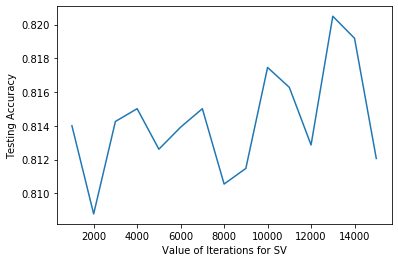

In [36]:
# the parameter we will change here is the max_iter
sv_range = range(1000, 16000, 1000)
sv_scores = {}
sv_scores_list = []

for it in sv_range:
    sv_model = LinearSVC(max_iter= it)
    sv_model.fit(X_train, y_train)
    sv_y_pred = sv_model.predict(X_test)
    sv_scores[k] = metrics.accuracy_score(y_test, sv_y_pred)
    sv_scores_list.append(metrics.accuracy_score(y_test, sv_y_pred))
    
# Now using the values of the loop to plot a graph with the performance
# ploting the relationship between K and the testing accuracy:
%matplotlib inline
plt.plot(sv_range, sv_scores_list)
plt.xlabel('Value of Iterations for SV')
plt.ylabel('Testing Accuracy')

In [37]:
max(sv_scores)

1000

The accuracy level didn't change with the increase of maximum iterations, so for comparison with the other models it will be used the previous result with the default value of 1000 maximum iterations

### Based on the results, the Random Forest is the most promising algorithm, as it has a recall and F1 scores higher than the other two.

## Performing Hyperparameter tunning

In [0]:
# First, create a list with the hyper parameters we want to change

# number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# number of features at every split
max_features = ['auto', 'sqrt']
# max depth
max_depth = [int(x) for x in np.linspace(100, 500, num = 10)]
max_depth.append(None)

# Now, create a grid
random_grid = {
 'n_estimators': n_estimators,
 'max_features': max_features,
 'max_depth': max_depth
 }

# Instatiate the classifier
rfc = RandomForestClassifier(n_jobs=-1)

# Random search of parameters
rfc_random = RandomizedSearchCV(estimator = rfc, param_distributions = random_grid, n_iter = 100, cv = 5,\
                                verbose=2, random_state=24, n_jobs = -1)

# Fit the model
best_model = rfc_random.fit(X_train, y_train)

# print results
print(best_model.best_params_)
print(best_model.best_score_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


# Evaluating Performance

In [0]:
upsampled_model = RandomForestClassifier(n_estimators=1000,
                                        max_features= 'auto',
                                        max_depth= 233).fit(X_train, y_train)

# prediction
upsampled_pred = upsampled_model.predict(X_test)

In [0]:
# Now we are going to evaluate results with cross validation, AUC-ROC
rf_cv_score = cross_val_score(upsampled_model, X, y, cv=10, scoring='roc_auc')

In [0]:
# And finally, let's display the results:

print("=== Confusion Matrix ===")
print(confusion_matrix(y_test, upsampled_pred))
print('\n')
print("=== Classification Report ===")
print(classification_report(y_test, upsampled_pred))
print('\n')
print("=== All AUC Scores ===")
print(rf_cv_score)
print('\n')
print("=== Mean AUC Score ===")
print("Mean AUC Score - Random Forest: ", rf_cv_score.mean())

This is a massive improvement, let's compare:

- Increase from 82% to 93% accuracy;
- Minority class: recall augmented from 30% to 96%
- Majority class: recall reduced from 96% to 93%